In [1]:
import xarray as xr
import numpy as np
import cmocean # for perceptually uniform colormaps
import cartopy as cr # for geographic mapping
import cartopy.crs as ccrs # for map projections
import matplotlib.pyplot as plt # plotting tool
import cartopy.feature as cfeature # to add coastlines, land and ocean
from cartopy import config
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfea
from netCDF4 import Dataset
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib as mpl
import pandas as pd
import datetime
import os
from datetime import datetime
import matplotlib.patheffects as PathEffects
import geocat.viz as gv
import cmaps
import geocat.viz as gv
import geocat.viz.util as gvutil
from scipy import stats
from mpl_toolkits.basemap import Basemap, cm, shiftgrid, addcyclic
from scipy import signal
from scipy import stats
import math
import iris

import numpy as np
import pandas as pd
import xarray as xr
import os
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats
import numpy as np
from scipy import signal
import numpy.polynomial.polynomial as poly
from netCDF4 import Dataset

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from eofs.standard import Eof
#from geocat.comp import eofunc_eofs, eofunc_pcs

import pint
import pint_pandas

In [2]:
#Saved file
ifile_output ='C:/Users/user/Research/Research Code/CNN/trainning/channelwise_Nonnormalised/'
ifile_data = 'C:/Users/user/Research/Research Code/CNN/Data/'
ifile_soda= 'C:/Users/user/Research/Research Code/CNN/trainning/Soda/'
ifile_sst = 'C:/Users/user/Research/Research Code/CNN/trainning/Heatcontent/'
outdir_original_pred = 'C:/Users/user/Research/Research Code/CNN/CW_PDO/original/pred/'
outdir_original_test = 'C:/Users/user/Research/Research Code/CNN/CW_PDO/original/test/'
outdir_original_valid = 'C:/Users/user/Research/Research Code/CNN/CW_PDO/original/validation/'
outdir_smooth_pred = 'C:/Users/user/Research/Research Code/CNN/CW_PDO/smoothed/pred/'
outdir_smooth_test= 'C:/Users/user/Research/Research Code/CNN/CW_PDO/smoothed/test/'
outdir_smooth_valid= 'C:/Users/user/Research/Research Code/CNN/CW_PDO/smoothed/validation/'
outdir_correlation = 'C:/Users/user/Research/Research Code/CNN/CW_PDO/correlation/'
ifile_soda ='C:/Users/user/Research/Research Code/CNN/Soda/training/'

ifile_world = 'C:/Users/user/Research/Research Code/CNN/trainning/world predicted/'
ifile_mech = 'C:/Users/User/Research/Research Code/CNN/Mechanism/Data/'
outdir = 'C:/Users/User/Research/Research Code/CNN/Mechanism/'

In [3]:
##Set up all functions
def weighted_areamean(ds):
    '''area mean weighted by cos of latitude'''
    weights = xr.ufuncs.cos(np.deg2rad(ds.lat))
    norm = np.sum(weights) * len(ds.lon)
    amean = (ds*weights).sum(('lat','lon')) / norm

    return amean


def acc_score(x,y):
    '''timestepwise anomaly correlation coefficient, averaged over time
        (simple version without seasonal climatoloty)'''
    assert(x.shape==y.shape)
    return np.mean([np.corrcoef(x[i].flatten(),y[i].flatten())[0,1] for i in range(len(x))])


def corr_over_time(x,y):
    '''timestepwise anomaly correlation coefficient, averaged over time
        (simple version without seasonal climatoloty)'''    
    mx = x[0:i].mean()
    my = y[0:i].mean()
    xm, ym = x[0:i]-mx, y[0:i]-my
    r_num = (xm*ym).mean()
    r_den = xm.std() * ym.std()
    r = r_num / r_den
        
    return r

def mean(x):
    avg = sum(x)/len(x)
    return round(avg,2)


def adjust(ds):
    '''transform the data'''
    z1 = np.array(ds)
    df = pd.DataFrame (z1)
    pred = df.iloc[:,0]
    return pred 

def correlation(x,y,z):
    corr_test = np.corrcoef(x [0:i],y [0:i])[0,1]
    z.append(corr_test)
    
def lowpass_filter (x,y):
    '''fraction of nyquist frequency, here  it is 10 years'''
    fs=1/12/30/24/3600 

    nyquist = fs / 2 # 0.5 times the sampling frequency
    cutoff=x # fraction of nyquist frequency, here  it is 10 years
    b, a = signal.butter(5, cutoff, btype='lowpass') #low pass filter


    dUfilt = signal.filtfilt(b, a, y)
    dUfilt=np.array(dUfilt)
    dUfilt=dUfilt.transpose()
    return dUfilt

def avg(myArray, N=12):
    '''average every 12 months'''
    cum = np.cumsum(myArray,0)
    result = cum[N-1::N]/float(N)
    result[1:] = result[1:] - result[:-1]

    remainder = myArray.shape[0] % N
    if remainder != 0:
        if remainder < myArray.shape[0]:
            lastAvg = (cum[-1]-cum[-1-remainder])/float(remainder)
        else:
            lastAvg = cum[-1]/float(remainder)
        result = np.vstack([result, lastAvg])

    return result

def detrend_dim(da,trend, dim, deg=1):
    '''detrend along a single dimension'''
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(trend[dim], p.polyfit_coefficients)
    return da - fit

# Contour from SST

In [4]:
ds = xr.open_dataset(ifile_data+'nonnormalized_ersst_1854_2022.nc')
ds

<xarray.Dataset>
Dimensions:  (lev: 1, lat: 89, lon: 180, time: 2028)
Coordinates:
  * lev      (lev) float64 0.0
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2022-12-01
Data variables:
    sst      (time, lat, lon, lev) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2023-01-04

In [5]:
# === Climatology and Anomalies
# ----- Parameter setting ------

ystr = 1983
yend = 1996

# == netcdf file name and location"
ifile = 'C:/Users/User/Research/Research Code/CNN/Data/'
fnc = ifile+'ersst_1854_2022_mech.nc'
dmask = xr.open_dataset(ifile+'lsmask.nc')
ds = xr.open_dataset(fnc)

##Slice the area
sst = ds.sst.sel(lat=slice(89, -89,1), lon=slice(0, 360,1))
clm = sst.sel(time=slice(f'{ystr}-01-01',f'{yend}-12-01')).groupby('time.month').mean(dim='time')
contour_sst = sst.sel(time=slice(f'{ystr}-01-01',f'{yend}-12-01')).groupby('time.month') - clm

##Normalized
mm = contour_sst.mean(('time','lat','lon'))
std = contour_sst.std(('time','lat','lon'))

mm.load()
std.load()

normalized_sst = contour_sst
normalized_sst = normalized_sst.sel(time=slice(f'{1996}-05-01',f'{1996}-07-01')).mean(dim='time')
print(normalized_sst.shape)

(89, 180)


In [6]:
contour = np.zeros(normalized_sst.shape, dtype=np.float32)

for i in range(normalized_sst.shape[0]):
    contour[:,:] = normalized_sst[:,:]

lat_atae = contour[:,0] # latitude is the same size as the first axis
lon_atae = contour[0,:] # longitude is the same size as second axis

data_xr = xr.DataArray(contour,
coords={'lat': lat_atae,'lon': lon_atae,},
dims=["lat", "lon"])

print(data_xr.shape)


(89, 180)


In [7]:
#create NetCDF4

testsizepath='C:/Users/user/Research/Research Code/CNN/y_test/y_testsize_89_180.nc'
y_test_size= xr.open_dataarray(testsizepath)

y_test_predicted_new = xr.DataArray(data=data_xr, coords=y_test_size.coords, dims=y_test_size.dims)


# save the predictions
fnc = outdir+'contour_sst.nc'
y_test_predicted_new.to_netcdf(fnc)


In [8]:
##open NetCDF of land mask
dmask = xr.open_dataset(ifile+'lsmask.nc')
ds = xr.open_dataarray(fnc)
ystr = 1983
yend = 2022

ds

<xarray.DataArray (lat: 89, lon: 180)>
array([[-1.192093e-07, -1.192093e-07, -1.192093e-07, ..., -1.192093e-07,
        -1.192093e-07, -1.192093e-07],
       [-1.192093e-07, -1.192093e-07, -1.192093e-07, ..., -1.192093e-07,
        -1.192093e-07, -1.192093e-07],
       [-1.192093e-07, -1.192093e-07, -1.192093e-07, ..., -1.192093e-07,
        -1.192093e-07, -1.192093e-07],
       ...,
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

In [9]:
# -- Detorending
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

contour_sst=ds
print(contour_sst)

<xarray.DataArray (lat: 89, lon: 180)>
array([[-1.192093e-07, -1.192093e-07, -1.192093e-07, ..., -1.192093e-07,
        -1.192093e-07, -1.192093e-07],
       [-1.192093e-07, -1.192093e-07, -1.192093e-07, ..., -1.192093e-07,
        -1.192093e-07, -1.192093e-07],
       [-1.192093e-07, -1.192093e-07, -1.192093e-07, ..., -1.192093e-07,
        -1.192093e-07, -1.192093e-07],
       ...,
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0


In [10]:
contour = np.zeros(normalized_sst.shape, dtype=np.float32)
for i in range(normalized_sst.shape[0]):
    contour[:,:] = normalized_sst[:,:]

In [11]:
lat_atae = contour[:,0] # latitude is the same size as the first axis
lon_atae = contour[0,:] # longitude is the same size as second axis


data_xr = xr.DataArray(contour,
coords={'lat': lat_atae,'lon': lon_atae,},
dims=["lat", "lon"])

testsizepath='C:/Users/user/Research/Research Code/CNN/y_test/y_testsize_89_180.nc'
y_test_size= xr.open_dataarray(testsizepath)

y_test_predicted_new = xr.DataArray(data=data_xr, coords=y_test_size.coords, dims=y_test_size.dims)


# saved to Netcdf
fnc = outdir+'combine_contour.nc'
y_test_predicted_new.to_netcdf(fnc)

print(data_xr.shape)


(89, 180)


In [12]:
dmask = xr.open_dataset(ifile+'lsmask.nc')
#Open with xarray
contour_combine = xr.open_dataarray(fnc)

contour_combine

<xarray.DataArray (lat: 89, lon: 180)>
array([[-1.192093e-07, -1.192093e-07, -1.192093e-07, ..., -1.192093e-07,
        -1.192093e-07, -1.192093e-07],
       [-1.192093e-07, -1.192093e-07, -1.192093e-07, ..., -1.192093e-07,
        -1.192093e-07, -1.192093e-07],
       [-1.192093e-07, -1.192093e-07, -1.192093e-07, ..., -1.192093e-07,
        -1.192093e-07, -1.192093e-07],
       ...,
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

# Analyzing heatmap 

In [13]:
# === Climatology and Anomalies
# ----- Parameter setting ------
ystr = 1878
yend = 2023

# == netcdf file name and location"
fnc = ifile_world+'predictions_tuned_leadtime_worldmap_sst_1878_2022_0params_288_10_0.nc'

dmask = xr.open_dataset(ifile+'lsmask.nc')
ds = xr.open_dataset(fnc)

#Slice area
sst = ds.__xarray_dataarray_variable__.sel(lat=slice(88, -88,10), lon=slice(0, 360,10))

#Calculate anomaly
clm = sst.sel(time=slice(f'{ystr}-01-01',f'{yend}-12-01')).groupby('time.month').mean(dim='time')
anm = (sst.groupby('time.month') - clm)

sst=anm.rolling(time=3, center=True).mean('time')

sst=anm


# -- Detorending
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

sst=detrend_dim(sst,'time',1)

sst = sst.sel(time=slice(f'{ystr}-01-01',f'{yend}-12-01'))
sst


print(sst.shape)

(1740, 9, 18, 1)


In [14]:
combine = np.zeros(sst.shape, dtype=np.float32)
for i in range(sst.shape[0]):
    combine[i,:,:] = sst[i,:,:]

In [15]:
ext_heatmap = combine
std_heatmap = np.std(ext_heatmap,axis=0)
mean_heatmap = np.mean(ext_heatmap,axis=0)

In [16]:
# significant test
mask_heatmap = np.zeros((1740,9,18),dtype=np.float32)
for i in range(1740):
  for j in range(9):
    for k in range(18):
      level = abs(ext_heatmap[i,j,k]-mean_heatmap[j,k])/(std_heatmap[j,k]/np.sqrt(1741))
      if level > 2.56:
        mask_heatmap[i,j,k] = ext_heatmap[i,j,k]

C:\Users\User\AppData\Local\Temp\ipykernel_26488\4147358734.py:6: RuntimeWarning: divide by zero encountered in divide
  level = abs(ext_heatmap[i,j,k]-mean_heatmap[j,k])/(std_heatmap[j,k]/np.sqrt(1741))


In [17]:
heatmap_cor = np.zeros(mask_heatmap.shape, dtype=np.float32)

for i in range(mask_heatmap.shape[0]):
    heatmap_cor[i,:,:] = mask_heatmap[i,:,:]

time_atae = heatmap_cor[:,0,0] # time is the 3rd axis
lat_atae = heatmap_cor[0,:,0] # latitude is the same size as the first axis
lon_atae = heatmap_cor[0,0,:] # longitude is the same size as second axis


data_xr = xr.DataArray(heatmap_cor,
coords={'time': time_atae,'lat': lat_atae,'lon': lon_atae,},
dims=["time","lat", "lon"])

print(data_xr.shape)

testsizepath='C:/Users/user/Research/Research Code/CNN/y_test/y_testsize_1740_9_18.nc'
y_test_size= xr.open_dataarray(testsizepath)

y_test_predicted_new = xr.DataArray(data=data_xr, coords=y_test_size.coords, dims=y_test_size.dims)

(1740, 9, 18)


In [18]:
# save the predictions
fnc_large_sst = outdir+'mask_heatmap_large_pred_1854_2022.nc'
y_test_predicted_new.to_netcdf(fnc_large_sst)

In [19]:
dmask = xr.open_dataset(ifile+'lsmask.nc')
heatmap_large = xr.open_dataarray(fnc_large_sst)

heatmap_large=heatmap_large.sel(time=slice(f'{1996}-07-01',f'{1996}-09-01')).mean(dim='time')

In [20]:
# -- figure plot

def makefig(cor,map1, title):
  
  cor = gvutil.xr_add_cyclic_longitudes(cor, 'lon')

  # Generate axes using Cartopy to draw coastlines
  ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=180))
  ax.coastlines(linewidth=0.5, alpha=0.6)

  # Use geocat.viz.util convenience function to set axes limits & tick values
  gvutil.set_axes_limits_and_ticks(ax,
                                 xlim=(-180, 180),
                                 ylim=(-70, 70),
                                 xticks=np.arange(-180, 180, 60),
                                 yticks=np.arange(-70, 70, 40))


  # Use geocat.viz.util convenience function to make latitude, longitude tick labels
  gvutil.add_lat_lon_ticklabels(ax)

  # Import the default color map
  newcmp = cmaps.BlueYellowRed
  index = [5, 20,  35, 50, 65, 85, 95, 110, 125,  0, 0, 135, 150,  165, 180, 200, 210, 220, 235, 250 ]
  color_list = [newcmp[i].colors for i in index]
  #-- Change to white
  color_list[9]=[ 1., 1., 1.]
  color_list[10]=[ 1., 1., 1.]

  # Define dictionary for kwargs
  kwargs = dict(
    vmin = -1,
    vmax = 1,
    levels = 21,
    #colors=color_list,
    add_colorbar=False,  # allow for colorbar specification later
    transform=ccrs.PlateCarree(),  # ds projection
    cmap = mpl.cm.get_cmap('RdBu_r')
  )


  # Use geocat.viz.util convenience function to add titles to left and right of the plot axis.
  gvutil.set_titles_and_labels(ax,
                             lefttitle=title,
                             lefttitlefontsize=16,
                             righttitle='',
                             righttitlefontsize=16,
                             xlabel="",
                             ylabel="")

  # Plot data
  cax1 = plt.imshow(map1[:,:], cmap='RdBu_r',clim=[-15,15], extent=[-180,180,-89,89],zorder=0)

  # Draw map features on top of filled contour
  ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=3,)
  ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5, zorder=3)

  # Plot line contours
  # Specify contour levels 
  delc=0.5
  levels = np.arange(-1.0, 0, delc)
  levels = np.append(levels, np.arange(delc, 1.1, delc))
  rad = cor.plot.contour(ax=ax,
                  colors='black',
                  alpha=0.8,
                  linewidths=1.0,
                  add_labels=False,
                  levels=levels,
                  transform=ccrs.PlateCarree())
  ax.clabel(rad, levels, fmt='%1.1f',  inline=True, colors='black', fontsize=8,)
  pe = [PathEffects.withStroke(linewidth=2.0, foreground="w")]
  plt.setp(rad.collections, path_effects=pe,zorder=2, alpha=0.8)

  return ax, cax1,cax2

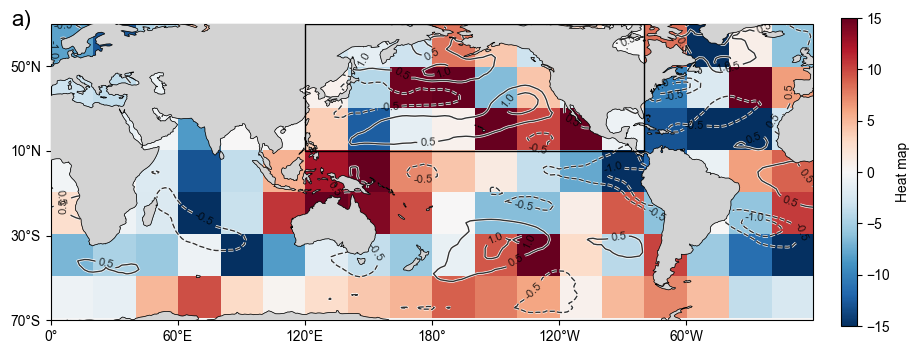

<Figure size 640x480 with 0 Axes>

In [21]:
# Plotted the heatmap
fig = plt.figure(figsize=(12, 4))
plt.rcParams["font.family"] = "Arial"

ax1, fill1 = makefig(normalized_sst[:,:],heatmap_large,'')

fig.colorbar(fill1,
                 ax=[ax1],
                 orientation='vertical',
                 shrink=1,aspect = 20,
                 pad=0.03,
                 extendfrac='auto',
                 extendrect=True,label = 'Heat map')

#plot square over North Pacific ocean
a= [   100,   -60,  -60,   100, 100]
b = [  10,   10,    70,    70,   10]
plt.plot(a,b,'black',linewidth=1,zorder=4)

plt.ylabel('')
fig.suptitle('a)', fontsize=16, x=0.1, y=0.9)

plt.savefig(outdir+'Heatmap analysis_contour_sst_heatmap_analysis_PDO_large pixel'+'.png',bbox_inches='tight')
plt.show()
plt.draw()

# END